In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## January Flight Delays - Decision Tree Models
This notebook is an early analysis of the January Flight Delay Prediction.  I used a Decision Tree Analysis to build a predictive model to predict the amount of delays on the arrival destination.  Some parts may run slow, due to one hot encoding of a very large dataset.  Feel free to add any comments or issues. 

In [ ]:
#%%  Read both csv files
## Reading csv files and adding them
filepath1 = os.path.join(dirname, filenames[0])
filepath2 = os.path.join(dirname, filenames[1])
df1 = pd.read_csv(filepath1)
df2 = pd.read_csv(filepath1)
print(df1.shape)
print(df2.shape)
df = pd.concat([df1, df2], ignore_index=True)
print(df.info())
del(df1)
del(df2)
seed = 1001

## Picking relevant columns
I want do drop some columns from the data frame as many columns are redundant.  Here are some of the columns/notes
- 'OP_UNIQUE_CARRIER' and 'OP_CARRIER' are redundant were eliminated.
- 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID' are redundant and mean the same thing, used Origin instead.
- 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID' are redundant used 'DEST' insead
- Did not use 'DEP_TIME_BLK', instead rounded the departure times and arrival times down in a further section.
- 'Unnamed: 21' not used and removed

In [ ]:
column1 = ['DAY_OF_MONTH', 'DAY_OF_WEEK','OP_CARRIER_AIRLINE_ID', 'TAIL_NUM','OP_CARRIER_FL_NUM',
 'DEST','DEP_TIME','DEP_DEL15', 'ARR_TIME', 'ARR_DEL15', 
 'CANCELLED','DIVERTED', 'DISTANCE']


df = df[column1]

# Drops rows with na values from dataframe.
df.dropna(inplace=True)

Data set has a slight class imbalance, as there are less delays than not delays, however I think a model can still run and predict well. 

In [ ]:
## Data set has a class imbalance.  There are 921482 flights that weren't delayed, however 
## there were only 210444 flights that were delayed.  I have tried to add more balance by downsampling the 
## number of not delayed classes.

not_delay = df[df['ARR_DEL15']==0]
delay = df[df['ARR_DEL15']==1]

print(len(not_delay))
print(len(delay))

## Encoding for Column Tail Number
I assume TAIL_Num is the number to label a plane.  I wanted to break down planes based on the amount of delays they had.

In [ ]:
df2 = df[['TAIL_NUM', 'ARR_DEL15']]
df2 = df2.groupby(['TAIL_NUM']).sum()
df2 = df2.sort_values(by=['ARR_DEL15'], ascending=False)
df2.columns = ['tail_delay']

## Plots histogram of the amount of delays each plane has experienced.

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df2['tail_delay'], 8, facecolor='green', alpha=0.75)
plt.xlabel('Number of Flight Delays')
plt.ylabel('Counts')
plt.title(r'Histogram of flight delays a plane has')

Based on the histogram, I decided to create a column tail_delay which groups the planes on how many delays they had. I split into 7 columns, where 6 is a high number of delays and 0 is low number of delays.  ALso I rounded the columns DEP_TIME and ARR_TIME.

In [ ]:
## Converts TAIL_NUM into a category from 1-6 based on the amount of delays the plane has
df2['tail_delay'] = np.floor(df2['tail_delay']/20)
df = pd.merge(df, df2, on='TAIL_NUM')
del(df2)
df.drop(columns = ['TAIL_NUM'], inplace=True)

## rounds departure time down to the nearest hour. Example 6:15 or 6:45 would be both be rounded to 6.
df['DEP_TIME'] = round((df['DEP_TIME']/100), 0)
df['DEP_TIME']  = df['DEP_TIME'].astype(int)
df['ARR_TIME'] = round((df['ARR_TIME']/100), 0)
df['ARR_TIME']  = df['ARR_TIME'].astype(int)  

## Encoding for Column DEST
Wanted to do a similar strategy for the column DEST which is the departure city.

In [ ]:
import matplotlib.pyplot as plt
column = 'DEST'
df2 = df[[column, 'ARR_DEL15']]
df2 = df2.groupby(column).sum()
df2 = df2.sort_values(by=['ARR_DEL15'], ascending=False)
df2.columns = ['city_delay']

##plt.boxplot(df2['delay_counts'], notch=True)
plt.hist(df2['city_delay'], 8, facecolor='green', alpha=0.75)
plt.xlabel('Number of Flight Delays')
plt.ylabel('Counts')
plt.title(r'Histogram of Flight Delays based on Destination Airport')

In [ ]:
df2['city_delay'] = np.floor(df2['city_delay']/1000)
df = pd.merge(df, df2, on=column)
del(df2)
df.drop(columns = column, inplace=True)

## One Hot Encoding Code
The column 'OP_CARRIER_AIRLINE_ID' is a categorical columns.  I chose to use one hot encoding to convert the columns
in a usable format. Label encoding assigns a number value to each value in the column. For example one airline ID '20363' would have a value of 1
and airline id '19805' would have a value of 2.  However the issue is that the model may infer a numerical relationship between 
these values so it is easier to use One Hot Encoding to convert each variable into a feature/column. column2 is a list containing the names of all the columns to convert using one hot encoding.

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

column2 = ['OP_CARRIER_AIRLINE_ID', 'tail_delay', 'city_delay']

for col in column2:
    enc = OneHotEncoder(sparse = False, handle_unknown='ignore')
    encoded_frame = enc.fit_transform(np.array(df[col]).reshape(-1,1))
    column_name = enc.get_feature_names()
    column_name = col + column_name
    one_hot_encoded_frame =  pd.DataFrame(encoded_frame, columns= column_name)
    
    df = pd.concat([df, one_hot_encoded_frame], axis=1)
    del(encoded_frame)
    del(one_hot_encoded_frame)
    df.drop(columns = col, inplace=True)


## splitting data into training and test sets.
Used 80/20 split for training and evaluation

In [ ]:
#%%    splitting data into training and test sets.
## 80/20 split for training and evaluation
split   = 0.8 
x_train = df.sample(frac=split, random_state=seed) 
x_test  = df.drop(x_train.index)
print(x_train.shape, x_test.shape)

# Extract and remove the label (to be predicted) set
y_train = x_train.pop('ARR_DEL15')
y_test  = x_test.pop('ARR_DEL15')
print(y_train.shape, y_test.shape)

## Training Decision Tree Model
Decision trees are a good model to use because they are easy to implement and understand the results.  They work by splitting/partitioning the data based on features that have the lowest misclassification rate of the predicted value.
Once the data is split enough, it will make a final decision based on the rules and probabilities given by the tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 0)
clf.fit(x_train, y_train) 

## Graphing Decision Tree
I used GraphViz package to plot the Decision tree as it seemed cleaner and neater than just plotting through matplotlib.  If running on your local machine you would need to pip install the GraphViz library and add to your PATH variable on Windows. I also set a max-depth to 3 for simplicity, so it doesn't show the entire tree, just the first three splits on the tree.  


In [ ]:
!pip install pydotplus

In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image 
dot_data = StringIO()
from sklearn import tree

tree.export_graphviz(clf, max_depth = 3, feature_names=x_test.columns, out_file= dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('tree.png')

Based on the tree below, the most important feature is if the plane departed late 'DEP_DEL15'.  After that split is made, the airline '19393' was probably an airline which had a lot of delays.  Then the features that split with lowest misclassification, was the day of the month and distance of the flight. 

In [ ]:
Image(graph.create_png())

## Model Evaluation
From sklearn I am using a confusion matrix, which helps to evaluate the performance of classification models.  Notes are below
* Positive (P) : Observation is positive, flight was delayed on arrival
* Negative (N) : Observation is not positive, flight was not delayed on arrival
* recall - ratio of correctly classified positive examples over total number of positive examples. recall = TP/(TP + FN)
* precision – ratio of correctly classified positive examples over total number of predicted positive examples. 
* Precision = TP(TP + FP).
* accuracy - ratio of correctly classified predictions over all of the predictions.  accuracy = (TP + TN)/(TP+TN+FP+FN)
* F1 score – helps measure both precision and recall at the same time.  
* F-measure = (2*recall * precision)/(recall + precision)


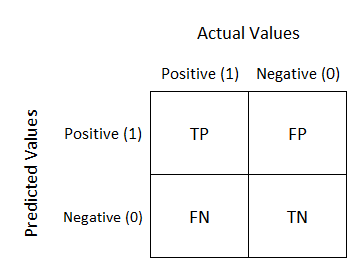

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  
y_predict = clf.predict(x_test)
cmatrix = confusion_matrix(y_test, y_predict) 
accuracy = accuracy_score(y_test, y_predict) 
classification_report = classification_report(y_test, y_predict) 

print(cmatrix)
print(classification_report)

##Cross Validation to find true accuracy of model

I Used cross validation package from sk-learn to run k-fold cross validation for 5 folds and append the scores to list results.  It will test the model several times across a subset of data, however I specified 5 subsets.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

x_test2 = df
y_test2 = x_test2.pop('ARR_DEL15')
scoring='f1_macro'
scores = cross_validate(clf, x_test2, y_test2, cv=5, scoring = ['accuracy', 'f1'])
results = list()
results.append([scores['test_accuracy'].mean(), scores['test_f1'].mean()])
print('The average accuracy is %f and the average F1 score is %f' %((results[0][0]),(results[0][1])))

###### ROC Curve
Reciever Operator Curves are a good way to illustrate a classification model, and plots the true positive rate against the false positive rate. The closer the graph is to the top and left-hand borders, the more accurate the test. The output was not the probabilities beween 0 and 1, so the ROC curvve isn't as smooth as compared to other models. The greater the area under the curve the more accurate the model is, with a uppder limit of 1, and .5 meaning it doesn'treally predict anything. The area under the curve is .96 which is good.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = clf.predict_proba(x_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In Conclusion this is my notebook on using a Decision Tree approach to the Flight Prediction Dataset. You could get higher accuracy using Random Forest models and boosted tree algorithms> However Decision Tree algorithms are a good way to start to visualize and interpret which variables that are important. I got a somewhat higher accuracy running my code on the kaggle than I did on my local machine. I cannot explain why.

This is my first Kaggle notebook, so I welcome any feedback or suggestions. Thanks for reading!